In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pickle
from numpy import asarray

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, RocCurveDisplay, confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, concatenate, LSTM, Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer  
from tensorflow.keras import backend


# DATASET
DATASET_COLUMNS = ['Id', 'Review', 'Sentiment']
# Define a dictionary to map sentiment values to category names
senti_labels = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
senti_categories = list(senti_labels.values())
NUM_of_CLASSES = 3


input_folder_path = "./pls/Thesis_Jupyter_Final/input/"
processed_folder_path = "./pls/Thesis_Jupyter_Final/processed"
data_filename = "reviews_data.csv"
cleaned_data_filename = "cleaned_data.csv"
vocab_filename = 'vocab.txt'

In [ ]:
train = pd.read_csv(os.path.join(input_folder_path, "train.csv"))
val = pd.read_csv(os.path.join(input_folder_path, "val.csv"))
test = pd.read_csv(os.path.join(input_folder_path, "test.csv"))

x_train = train['Review']
y_train = train['Sentiment']
x_val = val['Review']
y_val = val['Sentiment']
x_test = test['Review']
y_test = test['Sentiment']

x_train_encoded = np.load(os.path.join(processed_folder_path, "train_encoded_x.npy"))
y_train_encoded = np.load(os.path.join(processed_folder_path, "train_encoded_y.npy"))
x_val_encoded = np.load(os.path.join(processed_folder_path, "val_encoded_x.npy"))
y_val_encoded = np.load(os.path.join(processed_folder_path, "val_encoded_y.npy"))
x_test_encoded = np.load(os.path.join(processed_folder_path, "test_encoded_x.npy"))
y_test_encoded = np.load(os.path.join(processed_folder_path, "test_encoded_y.npy"))

vocab = pd.read_csv(os.path.join(processed_folder_path, vocab_filename))
vocab_size = len(vocab)

In [ ]:
def calculate_metrics(score):
    acc =  score[1]
    loss = score[0]

    print(f"Accuracy: {acc:.2%}")
    print(f"Loss: {loss:.2f}")
    
    return acc, loss

In [ ]:
def calculate_classification_report(y, y_pred, labels):
    report = classification_report(y, y_pred, labels=labels)
    print("Classification Report:\n", report)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cnf_mat = confusion_matrix(y_true, y_pred)
    mat_disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat, display_labels=labels)
    mat_disp = mat_disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f'Confusion Matrix')
    plt.show()

In [ ]:
def evaluate_model(model, model_name, x_encoded, y_encoded, y=None, only_metrics=True):    
    y_pred_prob = model.predict(x_encoded)

    print(f"*{model_name}")
    
    score = model.evaluate(x_encoded, y_encoded, verbose=0)
    calculate_metrics(score)
    
    senti_labels = ['negative', 'neutral', 'positive'] #TODO: to constants
    
    if not only_metrics:
        y_pred = np.argmax(y_pred_prob, axis=1) + 1
        calculate_classification_report(y, y_pred, labels=senti_labels)
        plot_confusion_matrix(y, y_pred, labels=senti_labels)

In [ ]:
def plot_roc_curve(prob_test_vec, y_test, labels):
    fig, ax = plt.subplots(figsize=(10, 10))
    labels = labels
    colors = cycle(['limegreen', 'dodgerblue', 'red'])
    for senti, color in zip(range(NUM_of_CLASSES), colors):
        RocCurveDisplay.from_predictions(
            y_test[:, senti],
            prob_test_vec[:, senti],
            name=f"ROC curve for {labels[senti]}",
            color=color,
            ax=ax,
        )

In [ ]:
def one_hot_encode(y):
    y_encoded = np.zeros((len(y), NUM_of_CLASSES))
    for i, label in enumerate(y):
        y_encoded[i, label - 1] = 1

    return y_encoded

In [ ]:
def calculate_OvR_roc_auc_score(model, x, y, x_test, y_test, labels): #average??
    y = one_hot_encode(y)
    y_test = one_hot_encode(y_test)

    ovr_model = OneVsRestClassifier(model).fit(x, y)
    prob_test_vec = ovr_model.predict_proba(x_test)
    
    fpr, tpr, thresholds, auc_score = [], [], [], []
    for _ in range(NUM_of_CLASSES):
        fpr.append(0)
        tpr.append(0)
        thresholds.append(0)
        auc_score.append(0)
    
    for i in range(NUM_of_CLASSES):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], prob_test_vec[:, i])
        auc_score[i] = auc(fpr[i], tpr[i])

    print(f"AUC score: {auc_score}")
    averaged_auc_score = (sum(auc_score) / NUM_of_CLASSES)
    print(f"Averaged AUC score: {averaged_auc_score:.2f}")
    
    plot_roc_curve(prob_test_vec, y_test, labels)

In [ ]:
def plot_development(history):
    acc = history.history['accuracy']
    loss = history.history['loss']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation Loss')
    plt.legend()
    
    plt.show()

# LSTM

Making a basic neural net to see the baseline for accuracy with minimum tuning.

In [ ]:
num_output_classes = 3
batch_size= 64
epochs= 3

In [ ]:
model = Sequential()
# input layer is sequence of integers (words)
model.add(Embedding(embedding_vocab_size, EMBEDDING_DIM, input_length=max_seq_length, name="embedding_layer")) # part of input layer as it transforms integers into dense vectors, input shape = (None, max_seq_length)
model.add(LSTM(64, name='hidden_layer')) # hidden layer
model.add(Dense(num_output_classes, activation='softmax', name="output_layer"))
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

basic_history = model.fit(x_train_encoded, y_train_encoded, validation_data=(x_val_encoded, y_val_encoded), batch_size=64, epochs=3)

accuracy = model.evaluate(x_test_encoded, y_test_encoded)[1]
print(f"Naive model Accuracy: {accuracy:.2f}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 238, 100)         154300    
                                                                 
 hidden_layer (LSTM)         (None, 64)                42240     
                                                                 
 output_layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 196,735
Trainable params: 196,735
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
100/100 [==============================] - 12s 101ms/step - loss: 0.4850 - accuracy: 0.8820 - val_loss: 0.4098 - val_accuracy: 0.8944
Epoch 2/3
100/100 [==============================] - 6s 65ms/step - loss: 0.4198 - accuracy: 0.8914 - val_loss: 0.4131 - val_accuracy: 0.8944
Epoch 3/3
63/63 [=========

For our naive model, we get an accuracy of x%. # TODO: x

## Hypterparameter Tuning

In [ ]:
num_lstm_layers = Integer(low=1, high=5, name='num_lstm_layers')
num_lstm_units = Integer(low=32, high=256, name='num_lstm_units') # TODO: step Keras Tuner
learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate')
adam_decay = Real(low=1e-6,high=1e-2,name="adam_decay")
batch_size = Integer(low=1, high=128, name='batch_size')

search_space = [
            num_lstm_layers,
            num_lstm_units,
            learning_rate,
            adam_decay,
            batch_size,
             ]

# Specify one or more initial points for the search of optimal parameter
default_params = [1,
                  32,
                  1e-3, 
                  1e-3,
                  64 
                ]

In [ ]:
def define_lstm_model(num_lstm_layers, num_lstm_units, learning_rate, adam_decay, embedding_vocab_size, embedding_dim, num_output_classes, max_length):
    # Start the model making process and create our first layer
    model = Sequential()
    model.add(Embedding(embedding_vocab_size, embedding_dim, input_length=max_length))

    # Create a loop making a new LSTM layer for the amount passed to this model.
    # Naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_lstm_layers):
        name = 'layer_lstm_{0}'.format(i+1)
        if i < num_lstm_layers-1:
            model.add(LSTM(num_lstm_units, return_sequences=True, name=name))
        else:
            model.add(LSTM(num_lstm_units, return_sequences=False, name=name))

    # Add our classification layer.
    model.add(Dense(num_output_classes, activation='softmax'))

    # Setup our optimizer and compile
    adam = Adam(learning_rate=learning_rate, decay=adam_decay)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    

    return model

In [ ]:
@use_named_args(dimensions=search_space)
def objective_function(num_lstm_layers, num_lstm_units, learning_rate, adam_decay, batch_size):

    model = define_lstm_model(num_lstm_layers=num_lstm_layers,
                         num_lstm_units=num_lstm_units,
                         learning_rate=learning_rate,
                         adam_decay=adam_decay,
                         embedding_vocab_size=embedding_vocab_size,
                         embedding_dim=EMBEDDING_DIM,
                         num_output_classes=num_output_classes,
                         max_length=max_seq_length
                        )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(x_train_encoded,
                        y_train_encoded,
                        validation_data=(x_val_encoded, y_val_encoded),
                        epochs=epochs, # TODO
                        batch_size=batch_size,
                        callbacks=[early_stopping]
                        )
    #return the validation accuracy for the last epoch.
    accuracy = history.history['val_accuracy'][-1]
    loss = history.history['val_loss'][-1]

    # Print the classification accuracy.
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Loss: {loss:.2}\n")


    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    backend.clear_session()
    tf.compat.v1.reset_default_graph()
    
    # the optimizer aims for the lowest score, so we return our negative accuracy
    return -accuracy

## Gaussian Process Model

In [ ]:
gp_result = gp_minimize(func=objective_function,
                            dimensions=search_space,
                            n_calls=12,
                            noise= 0.01,
                            n_jobs=-1,
                            kappa = 5,
                            x0=default_params)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 238, 100)          154300    
                                                                 
 layer_lstm_1 (LSTM)         (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 171,423
Trainable params: 171,423
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
100/100 [==============================] - 3s 17ms/step - loss: 0.5110 - accuracy: 0.8825 - val_loss: 0.4101 - val_accuracy: 0.8944
Epoch 2/3
100/100 [==============================] - 1s 11ms/step - loss: 0.4201 - accuracy: 0.8914 - val_loss: 0.4110 - val_accuracy: 0.8944
Epoch 3/3
100/100 [===========

In [ ]:
# TODO data frame summarizing parameter search
gp_best_params = {param.name: value for param, value in zip(gp_result.space, gp_result.x)}
print("Best Hyperparameters:", gp_best_params)

Best Hyperparameters: {'num_lstm_layers': 1, 'num_lstm_units': 32, 'learning_rate': 0.001, 'adam_decay': 0.001, 'batch_size': 64}


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 238, 100)          154300    
                                                                 
 layer_lstm_1 (LSTM)         (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 171,423
Trainable params: 171,423
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
400/400 [==============================] - 7s 13ms/step - loss: 0.4417 - accuracy: 0.8889 - val_loss: 0.4128 - val_accuracy: 0.8944
Epoch 2/20
400/400 [==============================] - 6s 14ms/step - loss: 0.4196 - accuracy: 0.8914 - val_loss: 0.4112 - val_accuracy: 0.8944
Epoch 3/20
400/400 [======

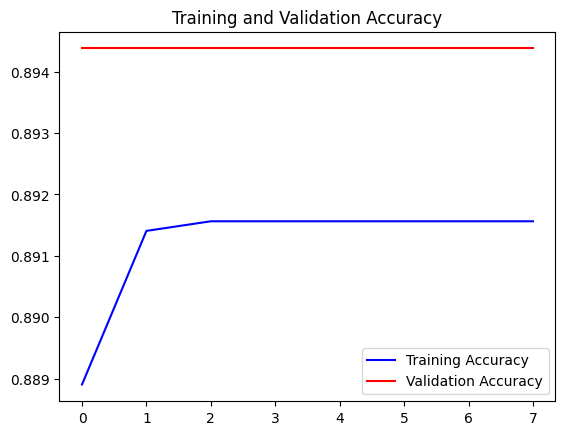

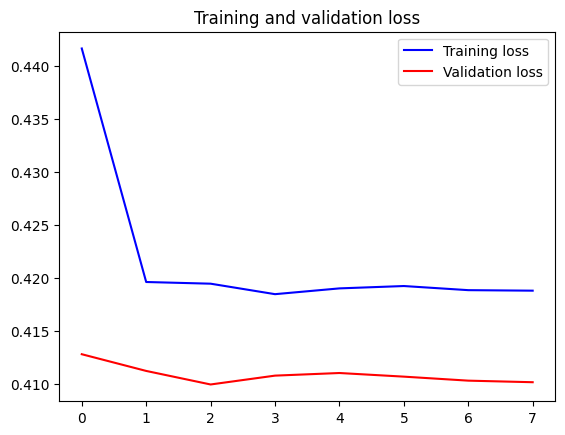

In [ ]:
model = define_lstm_model(gp_best_params['num_lstm_layers'], 
                          gp_best_params['num_lstm_units'], 
                          gp_best_params['learning_rate'], 
                          gp_best_params['adam_decay'],
                          embedding_vocab_size, EMBEDDING_DIM, num_output_classes, max_seq_length)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # TODO: should I, again?
history = model.fit(x_train_encoded,
                        y_train_encoded,
                        validation_data=(x_val_encoded, y_val_encoded),
                        epochs=20, # TODO
                        batch_size=16,
                        callbacks=[early_stopping]
                        )
plot_development(history)

200/200 [==============================] - 2s 8ms/step
*Train single-LSTM
Accuracy: 89.16%
Loss: 0.42

50/50 [==============================] - 0s 8ms/step
*Val single-LSTM
Accuracy: 89.44%
Loss: 0.41

63/63 [==============================] - 0s 8ms/step
*Test single-LSTM
Accuracy: 89.05%
Loss: 0.42
Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       0.00      0.00      0.00         0
    positive       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0



/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/home2/s3985113/venv/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/s3985113/venv/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cvmfs/hpc.rug.nl/versions/2023.01/rocky

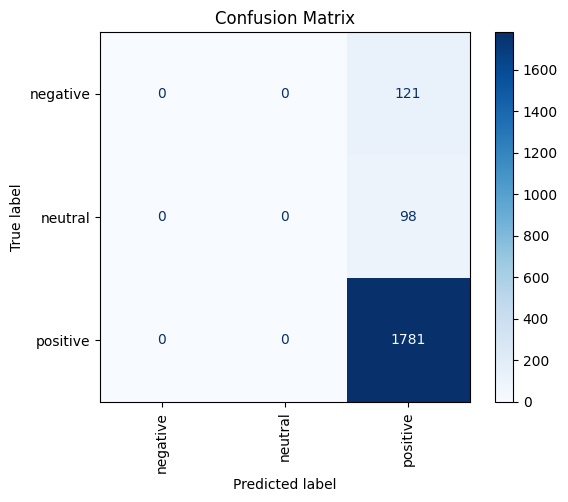

In [ ]:
model.evaluate(x_train_encoded, y_train_encoded)
evaluate_model(model, "Train single-LSTM", x_train_encoded, y_train_encoded, only_metrics=True)
print()

model.evaluate(x_val_encoded, y_val_encoded, verbose=0)
evaluate_model(model, "Val single-LSTM", x_val_encoded, y_val_encoded, only_metrics=True)
print()

model.evaluate(x_test_encoded, y_test_encoded, verbose=0)
evaluate_model(model, "Test single-LSTM", x_test_encoded, y_test_encoded, y_test, only_metrics=False)
print()

## Gradient Boosted Model

In [ ]:
gbrt_result = gbrt_minimize(func=objective_function,
                            dimensions=search_space,
                            n_calls=12,
                            n_jobs=-1,
                            x0=default_params)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 238, 100)          154300    
                                                                 
 layer_lstm_1 (LSTM)         (None, 32)                17024     
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 171,423
Trainable params: 171,423
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
100/100 [==============================] - 4s 21ms/step - loss: 0.4965 - accuracy: 0.8827 - val_loss: 0.4108 - val_accuracy: 0.8944
Epoch 2/3
100/100 [==============================] - 2s 18ms/step - loss: 0.4194 - accuracy: 0.8914 - val_loss: 0.4097 - val_accuracy: 0.8944
Epoch 3/3
100/100 [=========

In [ ]:
# TODO data frame summarizing parameter search
gbrt_best_params = {param.name: value for param, value in zip(gbrt_result.space, gbrt_result.x)}
print("Best Hyperparameters:", gbrt_best_params)

Best Hyperparameters: {'num_lstm_layers': 1, 'num_lstm_units': 32, 'learning_rate': 0.001, 'adam_decay': 0.001, 'batch_size': 64}


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 238, 100)          154300    
                                                                 
 layer_lstm_1 (LSTM)         (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 171,423
Trainable params: 171,423
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
400/400 [==============================] - 10s 20ms/step - loss: 0.4415 - accuracy: 0.8914 - val_loss: 0.4100 - val_accuracy: 0.8944
Epoch 2/20
400/400 [==============================] - 7s 18ms/step - loss: 0.4199 - accuracy: 0.8914 - val_loss: 0.4103 - val_accuracy: 0.8944
Epoch 3/20
400/400 [=====

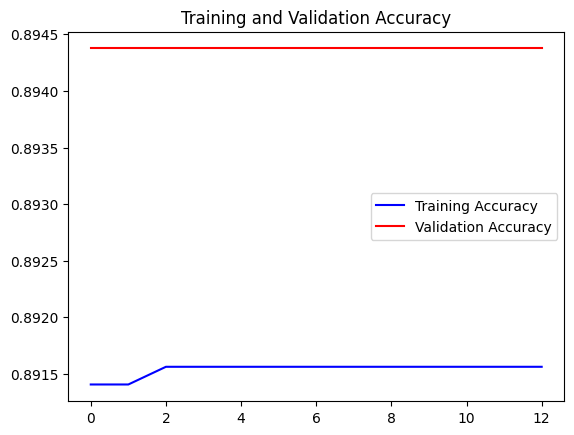

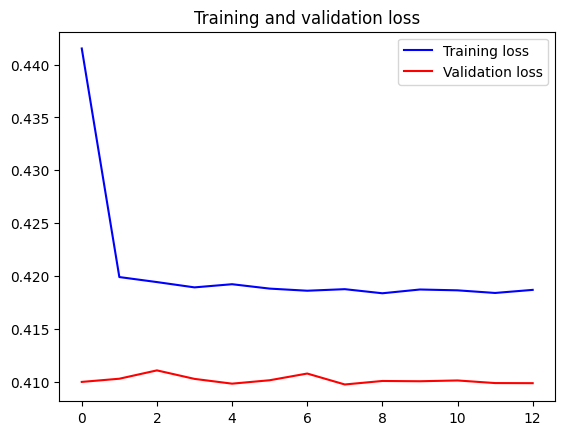

In [ ]:
model = define_lstm_model(gp_best_params['num_lstm_layers'], 
                          gp_best_params['num_lstm_units'], 
                          gp_best_params['learning_rate'], 
                          gp_best_params['adam_decay'],
                          embedding_vocab_size, EMBEDDING_DIM, num_output_classes, max_seq_length)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # TODO: should I, again?
history = model.fit(x_train_encoded,
                        y_train_encoded,
                        validation_data=(x_val_encoded, y_val_encoded),
                        epochs=20, # TODO
                        batch_size=16,
                        callbacks=[early_stopping]
                        )
plot_development(history)

200/200 [==============================] - 2s 8ms/step
*Train single-LSTM
Accuracy: 89.16%
Loss: 0.42

50/50 [==============================] - 0s 8ms/step
*Val single-LSTM
Accuracy: 89.44%
Loss: 0.41

63/63 [==============================] - 1s 8ms/step
*Test single-LSTM
Accuracy: 89.05%
Loss: 0.42
Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       0.00      0.00      0.00         0
    positive       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0



/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/home2/s3985113/venv/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/s3985113/venv/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cvmfs/hpc.rug.nl/versions/2023.01/rocky

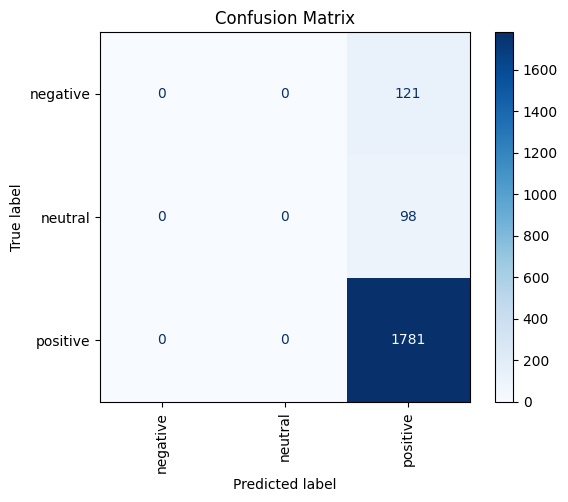

In [ ]:
model.evaluate(x_train_encoded, y_train_encoded)
evaluate_model(model, "Train single-LSTM", x_train_encoded, y_train_encoded, only_metrics=True)
print()

model.evaluate(x_val_encoded, y_val_encoded, verbose=0)
evaluate_model(model, "Val single-LSTM", x_val_encoded, y_val_encoded, only_metrics=True)
print()

model.evaluate(x_test_encoded, y_test_encoded, verbose=0)
evaluate_model(model, "Test single-LSTM", x_test_encoded, y_test_encoded, y_test, only_metrics=False)
print()

# Multi-Input

In [ ]:
num_lstm_layersA = Integer(low=1, high=5, name='num_lstm_layersA')
num_lstm_layersB = Integer(low=1, high=5, name='num_lstm_layersB')
num_lstm_unitsA = Integer(low=32, high=256, name='num_lstm_unitsA')
num_lstm_unitsB = Integer(low=32, high=256, name='num_lstm_unitsB')
learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate')
adam_decay = Real(low=1e-6,high=1e-2,name="adam_decay")
batch_size = Integer(low=1, high=128, name='batch_size')

search_space = [
            num_lstm_layersA,
            num_lstm_layersB,
            num_lstm_unitsA,
            num_lstm_unitsB,
            learning_rate,
            adam_decay,
            batch_size,
             ]

# Specify one or more initial points for the search of optimal parameter
default_params = [1, 
                  1, 
                  32,
                  32, 
                  1e-3,
                  1e-3,
                  64 
                  ]

In [ ]:
def define_multi_channel_lstm_model(num_lstm_layersA, num_lstm_layersB, num_lstm_unitsA, num_lstm_unitsB, learning_rate, adam_decay, embedding_vocab_size, embedding_dim, num_output_classes, max_length):
    # Vocabulary-based embedding layer
    inputsA = Input(shape=(max_seq_length,), name="input regular embeddings")
    # Word2Vec embedding layer
    inputsB = Input(shape=(max_seq_length,), name="input word2vec embeddings")
    
    # Define an embedding layer for each input
    embeddingsA = Embedding(embedding_vocab_size, embedding_dim, input_length=max_seq_length, name="embeddingsA")(inputsA)
    embeddingsB = Embedding(embedding_vocab_size, embedding_dim, input_length=max_seq_length, weights=[w2v_embedding_vectors], trainable=False, name="embeddingsB")(inputsB)
    
    # Pass both embeddings through their own LSTM layers
    lstm_layersA = embeddingsA
    for i in range(num_lstm_layersA):
        nameA = 'layer_lstmA_{0}'.format(i+1)
        if i < num_lstm_layers-1:
            lstm_layersA = LSTM(num_lstm_unitsA, return_sequences=True, name=nameA)(lstm_layersA)
        else:
            lstm_layersA = LSTM(num_lstm_unitsA, return_sequences=False, name=nameA)(lstm_layersA)
        
    lstm_layersB = embeddingsB
    for i in range(num_lstm_layersB):
        nameA = 'layer_lstmB_{0}'.format(i+1)
        if i < num_lstm_layers-1:
            lstm_layersA = LSTM(num_lstm_unitsB, return_sequences=True, name=nameA)(lstm_layersB)
        else:
            lstm_layersA = LSTM(num_lstm_unitsB, return_sequences=False, name=nameA)(lstm_layersB)
        

    # Concatenate the two inputs
    merged = concatenate([lstm_layersA, lstm_layersB])

    # Dense layer for the merged inputs & output Layer
    outputs = Dense(num_output_classes, activation='softmax', name="output")(merged)

    # Create the model
    model = Model(inputs=[inputsA, inputsB], outputs=outputs)

    # Compile the model
    adam = Adam(learning_rate=learning_rate, decay=adam_decay)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())

    return model

In [ ]:
@use_named_args(dimensions=search_space)
def multi_objective_function(num_lstm_layersA, num_lstm_layersB, num_lstm_unitsA, num_lstm_unitsB, learning_rate, adam_decay, batch_size):

    model = define_multi_channel_lstm_model(num_lstm_layersA=num_lstm_layersA,
                                            num_lstm_layersB=num_lstm_layersB,
                                            num_lstm_unitsA=num_lstm_unitsA,
                                            num_lstm_unitsB=num_lstm_unitsB,
                                            learning_rate=learning_rate,
                                            adam_decay=adam_decay,
                                            embedding_vocab_size=embedding_vocab_size,
                                            embedding_dim=EMBEDDING_DIM,
                                            num_output_classes=num_output_classes,
                                            max_length=max_seq_length
                                         )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(x_train_encoded,
                        y_train_encoded,
                        validation_data=(x_val_encoded, y_val_encoded),
                        epochs=epochs, # TODO
                        batch_size=batch_size,
                        callbacks=[early_stopping]
                        )
    #return the validation accuracy for the last epoch.
    accuracy = history.history['val_accuracy'][-1]
    loss = history.history['val_loss'][-1]

    # Print the classification accuracy.
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Loss: {loss:.2}\n")


    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    backend.clear_session()
    tf.compat.v1.reset_default_graph()
    
    # the optimizer aims for the lowest score, so we return our negative accuracy
    return -accuracy

## Gaussian Process Model

In [ ]:
gp_result = gp_minimize(func=multi_objective_function,
                            dimensions=search_space,
                            n_calls=12,
                            noise= 0.01,
                            n_jobs=-1,
                            kappa = 5,
                            x0=default_params)

TypeError: unsupported operand type(s) for -: 'Integer' and 'int'

In [ ]:
# TODO data frame summarizing parameter search
gp_best_params = {param.name: value for param, value in zip(gp_result.space, gp_result.x)}
print("Best Hyperparameters:", gp_best_params)

In [ ]:
model = define_multi_channel_lstm_model(gp_best_params['num_lstm_layersA'],
                          gp_best_params['num_lstm_layersB'],
                          gp_best_params['num_lstm_unitsA'], 
                          gp_best_params['num_lstm_unitsB'],
                          gp_best_params['learning_rate'], 
                          gp_best_params['adam_decay'],
                          embedding_vocab_size, EMBEDDING_DIM, num_output_classes, max_seq_length)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # TODO: should I, again?
history = model.fit(x_train_encoded,
                        y_train_encoded,
                        validation_data=(x_val_encoded, y_val_encoded),
                        epochs=20, # TODO
                        batch_size=16,
                        callbacks=[early_stopping]
                        )
plot_development(history)

In [ ]:
model.evaluate(x_train_encoded, y_train_encoded)
evaluate_model(model, "Train multi-LSTM", x_train_encoded, y_train_encoded, only_metrics=True)
print()

model.evaluate(x_val_encoded, y_val_encoded, verbose=0)
evaluate_model(model, "Val multi-LSTM", x_val_encoded, y_val_encoded, only_metrics=True)
print()

model.evaluate(x_test_encoded, y_test_encoded, verbose=0)
evaluate_model(model, "Test multi-LSTM", x_test_encoded, y_test_encoded, y_test, only_metrics=False)
print()

## Gradient Boosted Model

In [ ]:
gbrt_result = gbrt_minimize(func=objective_function,
                            dimensions=search_space,
                            n_calls=12,
                            n_jobs=-1,
                            x0=default_params)

In [ ]:
# TODO data frame summarizing parameter search
gbrt_best_params = {param.name: value for param, value in zip(gbrt_result.space, gbrt_result.x)}
print("Best Hyperparameters:", gbrt_best_params)

In [ ]:
model = define_multi_channel_lstm_model(gp_best_params['num_lstm_layersA'],
                          gp_best_params['num_lstm_layersB'],
                          gp_best_params['num_lstm_unitsA'], 
                          gp_best_params['num_lstm_unitsB'],
                          gp_best_params['learning_rate'], 
                          gp_best_params['adam_decay'],
                          embedding_vocab_size, EMBEDDING_DIM, num_output_classes, max_seq_length)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # TODO: should I, again?
history = model.fit(x_train_encoded,
                        y_train_encoded,
                        validation_data=(x_val_encoded, y_val_encoded),
                        epochs=20, # TODO
                        batch_size=16,
                        callbacks=[early_stopping]
                        )
plot_development(history)

In [ ]:
model.evaluate(x_train_encoded, y_train_encoded)
evaluate_model(model, "Train multi-LSTM", x_train_encoded, y_train_encoded, only_metrics=True)
print()

model.evaluate(x_val_encoded, y_val_encoded, verbose=0)
evaluate_model(model, "Val multi-LSTM", x_val_encoded, y_val_encoded, only_metrics=True)
print()

model.evaluate(x_test_encoded, y_test_encoded, verbose=0)
evaluate_model(model, "Test multi-LSTM", x_test_encoded, y_test_encoded, y_test, only_metrics=False)
print()